In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [30]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [31]:
filename = 'Dataset/Sensor_Discrimination_normalized.csv'
df=pd.read_csv(filename)
# shuffle the DataFrame rows
df = df.sample(frac = 1) #frac = fraction
dataset=df.iloc[:,:-1]
label=df.iloc[:,-1]
print(dataset)
print(label)

            F2        F3        F1       F11        F4        F6       F10  \
589   0.341176  0.848250  0.722233  0.187589  0.800931  0.292468  0.217432   
754   0.141005  0.903600  0.821156  0.197872  0.818892  0.478835  0.355233   
1547  0.425882  0.648721  0.384721  0.216667  0.514385  0.066767  0.271084   
164   0.192449  0.885262  0.761606  0.503191  0.946782  0.582188  0.965361   
1473  0.531979  0.851783  0.786484  0.215071  0.937635  0.199973  0.268637   
...        ...       ...       ...       ...       ...       ...       ...   
1307  0.766203  0.915040  0.833301  0.198227  0.842508  0.352666  0.388554   
1546  0.423957  0.633748  0.381783  0.206915  0.532014  0.068774  0.277673   
233   0.352086  0.806191  0.783350  0.190426  0.898054  0.308686  0.184526   
1761  0.790160  0.610532  0.371205  0.171631  0.507900  0.071798  0.285956   
1756  0.820321  0.572174  0.359647  0.213830  0.498586 -0.008725  0.269578   

            F9        F5      F7      F12      F8  
589   0.183

In [32]:
dataset_arr=dataset.to_numpy()
# from NecessaryModules.splitData import split_data
X_train, X_test, y_train, y_test = train_test_split(dataset_arr, label, test_size=0.3, random_state=42)
print(len(X_train))

1548


In [33]:
import pickle

# Load the encoder model from the saved file
with open("all_pkl_file/Encoder_3.pkl", "rb") as file: #"rb"= read mode
    encoder = pickle.load(file)

encoder


In [34]:
encoded_X = pd.DataFrame(encoder.predict(dataset))
encoded_X = encoded_X.add_prefix('feature_')

encoded_X_train = pd.DataFrame(encoder.predict(X_train))
encoded_X_train = encoded_X_train.add_prefix('feature_')

encoded_X_test = pd.DataFrame(encoder.predict(X_test))
encoded_X_test = encoded_X_test.add_prefix('feature_')



21/21 [==============================] - 0s 977us/step


# tune_MLP

In [35]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler(copy=True).fit(dataset)
encoded_X_n=scaler.transform(dataset)
encoded_X_train_n=scaler.transform(X_train)
encoded_X_test_n=scaler.transform(X_test)
encoded_X_train_n

array([[0.45240642, 0.74613055, 0.74338883, ..., 0.17968111, 0.2456    ,
        0.20158465],
       [0.83893048, 0.57015478, 0.34573947, ..., 0.10081766, 0.2793    ,
        0.14453711],
       [0.52256684, 0.82351952, 0.65093046, ..., 0.31790679, 0.2567    ,
        0.20058382],
       ...,
       [0.13238503, 0.90410498, 0.77375122, ..., 0.20911693, 0.038755  ,
        0.29724771],
       [0.85090909, 0.50992598, 0.23506366, ..., 0.07534751, 0.007445  ,
        0.05294412],
       [0.9826738 , 0.90629206, 0.85563173, ..., 0.39525756, 0.038515  ,
        0.36855713]])

In [36]:
# train the model with random parameter
from sklearn.neural_network import MLPClassifier

model_MLP = MLPClassifier(
     hidden_layer_sizes=120,
     random_state=42,
     max_iter=300,
     solver="adam"

     
     
     
        
     )

model_MLP.fit(encoded_X_train_n, y_train)

MLPClassifier(hidden_layer_sizes=120, max_iter=300, random_state=42)

In [37]:
# Finding mean absolute error
preds = model_MLP.predict(encoded_X_test_n)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.016566265060240965

In [38]:
#Use Optuna to find the best hyperparameters
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
K = 5 # stratified 5 fold cross validation, The folds are made by preserving the percentage of samples for each class.
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)

train_tunned= np.array(encoded_X_n)
target_train_tunned= np.array(label)

oof_preds= np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective_MLP(trial):

 for train_index, val_index in (skf.split(encoded_X_n,label)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    param={
        'hidden_layer_sizes':trial.suggest_int("hidden_layer_sizes", 150, 500),
        # solver=trial.suggest_categorical("solver", ["lbfgs", "sgd", "adam"]),
        'learning_rate':trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"]),
        'random_state':trial.suggest_int("random_state",0, 10),
        'max_iter':trial.suggest_int("max_iter",100,1000),
        'activation':trial.suggest_categorical("activation", ["logistic", "tanh", "relu"]),
        'batch_size':trial.suggest_int("batch_size",2,20),
        'verbose':False
    }
    model=MLPClassifier(**param)
    model.fit(train_X, train_Y)
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X
 mae = mean_absolute_error(target_train_tunned, oof_preds)
 return mae

In [39]:
# this is the main optuna for optimizing a object-->"objective"
import optuna
study_MLP = optuna.create_study(direction='minimize',study_name="MLP_tunning")

[I 2024-02-12 14:56:34,541] A new study created in memory with name: MLP_tunning


In [40]:

study_MLP.optimize(objective_MLP, n_trials=5) 
print('Number of finished trials:', len(study_MLP.trials))
print('Best trial:', study_MLP.best_trial.params)

[I 2024-02-12 14:57:43,455] Trial 0 finished with value: 0.009945750452079566 and parameters: {'hidden_layer_sizes': 201, 'learning_rate': 'adaptive', 'random_state': 4, 'max_iter': 163, 'activation': 'relu', 'batch_size': 6}. Best is trial 0 with value: 0.009945750452079566.
[I 2024-02-12 14:58:07,750] Trial 1 finished with value: 0.0325497287522604 and parameters: {'hidden_layer_sizes': 278, 'learning_rate': 'adaptive', 'random_state': 9, 'max_iter': 296, 'activation': 'tanh', 'batch_size': 7}. Best is trial 0 with value: 0.009945750452079566.
[I 2024-02-12 14:58:51,220] Trial 2 finished with value: 0.0076853526220614825 and parameters: {'hidden_layer_sizes': 426, 'learning_rate': 'constant', 'random_state': 6, 'max_iter': 329, 'activation': 'relu', 'batch_size': 12}. Best is trial 2 with value: 0.0076853526220614825.
[I 2024-02-12 15:00:22,392] Trial 3 finished with value: 0.024864376130198915 and parameters: {'hidden_layer_sizes': 365, 'learning_rate': 'invscaling', 'random_state':

Number of finished trials: 5
Best trial: {'hidden_layer_sizes': 184, 'learning_rate': 'invscaling', 'random_state': 8, 'max_iter': 466, 'activation': 'relu', 'batch_size': 20}


In [58]:
#evaluate the trial
print("Number of finished trials: ", len(study_MLP.trials))
print("Best trial:")
trial = study_MLP.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  5
Best trial:
  Value:  0.0054249547920434
  Params: 
    hidden_layer_sizes: 184
    learning_rate: invscaling
    random_state: 8
    max_iter: 466
    activation: relu
    batch_size: 20


In [59]:
from matplotlib import pyplot as plt
fig_study = optuna.visualization.plot_parallel_coordinate(study_MLP, params=["hidden_layer_sizes", "learning_rate","random_state","max_iter","batch_size"])
fig_study.show()

# fit tunned MLP

In [60]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train_MLP = np.array(encoded_X_train_n)
target_train_MLP= np.array(y_train)

test_MLP = np.array(encoded_X_test_n) # or test_Ada = np.array(X)


test_preds_MLP = np.zeros((len(test_MLP)))
oof_preds_MLP = np.zeros((len(train_MLP)))

for train_index, val_index in tqdm(skf.split(encoded_X_train_n,y_train), total=5):
    train_X, valid_X = train_MLP[train_index], train_MLP[val_index]
    train_y, valid_y = target_train_MLP[train_index], target_train_MLP[val_index]
    ada_params = study_MLP.best_trial.params
    model_MLP_2 = MLPClassifier(**ada_params,tol=.00001,early_stopping=True) # for early_stopping
    model_MLP_2.fit(train_X, train_y)
    # for train accuracy
    preds = model_MLP_2.predict(valid_X)
    oof_preds_MLP[val_index] = preds
    # for test accuracy
    preds = model_MLP_2.predict(test_MLP)
    test_preds_MLP += (preds)/5
print(np.abs(oof_preds_MLP-target_train_MLP).mean())

100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

0.053617571059431525


In [61]:
target_test_MLP = np.array(y_test)

In [62]:
from sklearn.metrics import accuracy_score
valid_Acc_MLP=accuracy_score(target_train_MLP,oof_preds_MLP)
print(valid_Acc_MLP)

# another technique for calculate test accuracy
test_Acc_MLP=accuracy_score(target_test_MLP,test_preds_MLP.round())
print(test_Acc_MLP)

0.9541343669250646
0.9487951807228916


In [63]:
train_Acc_MLP=model_MLP_2.score(encoded_X_train_n,y_train)
print(train_Acc_MLP)

0.9289405684754521


In [64]:
test_Acc_MLP=model_MLP_2.score(encoded_X_test_n,y_test)
print(test_Acc_MLP)

0.911144578313253


# Evaluation

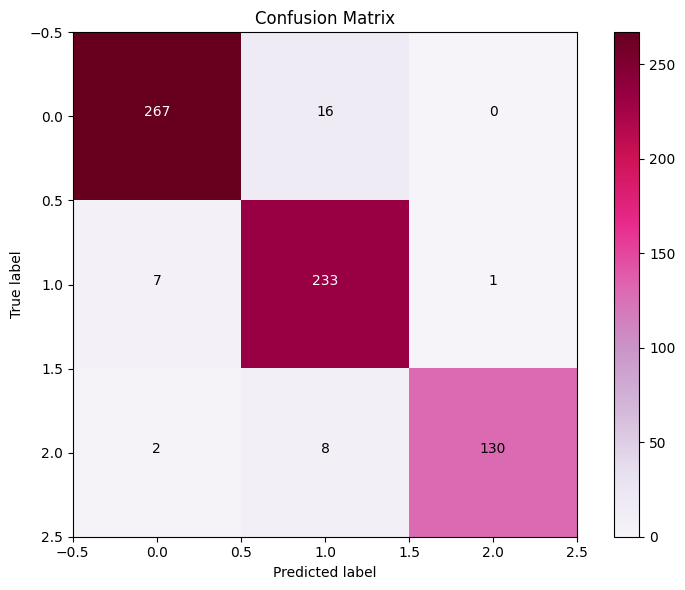

In [48]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds_MLP.round())
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()


# Learning _Curve


In [49]:
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier
################# it will take 0.8 as train data from the whole by-default ################
ada_params = study_MLP.best_trial.params
model_MLP_2 = MLPClassifier(**ada_params,tol=.00001,early_stopping=True) # for early_stopping
train_sizes, train_scores, test_scores = learning_curve(model_MLP_2, encoded_X_n, label, train_sizes=np.linspace(0.1, 1.0, 5))

In [50]:
#***** Calculate mean and standard deviation of train and test scores (as we got values for 5 fold cross in each row****)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

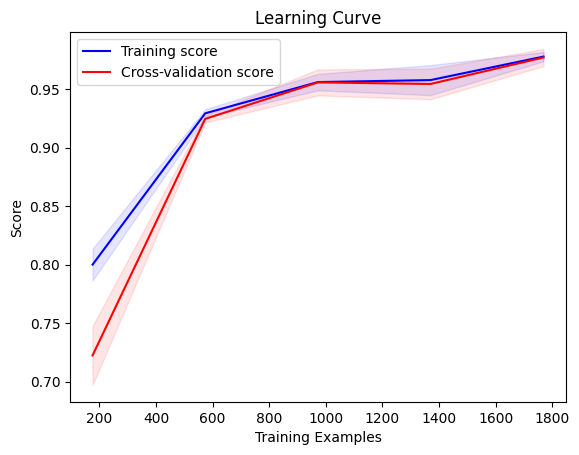

In [51]:
# Plot learning curves
plt.figure()
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1) #alpha=0.1: The transparency of the shaded region.
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='red')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.1)
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()